In [0]:
'''
Clean Recipe 1M+ Data
'''
import json
import pandas as pd
from pandas.io.json import json_normalize
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from nltk.stem import PorterStemmer
import re
import seaborn as sns

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
#recipes
with open('/content/drive/My Drive/CS 263 Project/Raw Data/layer1.json') as f:
  data = json.load(f)

ingredients = json_normalize(data,record_path='ingredients',meta="id")
instructions = json_normalize(data,record_path='instructions',meta="id")
recipes = pd.DataFrame(data)[["url","title","id"]]
del data

#turn ingredients and instructions into a single line in dataframe
ingredient_single_line = ingredients.groupby("id")['text'].agg(lambda column: " || ".join(column)).reset_index(name="text")
instructions_single_line = instructions.groupby("id")['text'].agg(lambda column: " || ".join(column)).reset_index(name="text")
del ingredients, instructions

#join single line ingredients and instructions with recipe header data
joined = pd.merge(recipes, ingredient_single_line, on=['id'], how='left')
joined = pd.merge(joined, instructions_single_line, on=['id'], how='left')
joined = joined.rename(columns={'url': 'url','title': 'title','id': 'id','text_x': 'ingredients','text_y': 'instructions'})
del ingredient_single_line, instructions_single_line

#search term
joined["combined1"] = joined["title"] + " --|||-- " + joined["instructions"] + " --|||-- " + joined["ingredients"] 

#limit to baking recipes
joined_limited = joined[joined['combined1'].str.contains("bake")].reset_index()
del joined

In [0]:
#ingredient labels
with open('/content/drive/My Drive/CS 263 Project/Raw Data/det_ingrs.json') as f:
  ils = json.load(f)
valid = json_normalize(ils,record_path='valid',meta="id")
ingredient_labels = json_normalize(ils,record_path='ingredients',meta="id")

#valid ingredients
ingredient_labels = ingredient_labels[valid[0] == True]
#turn ingredients into a single line in dataframe
ingredient_labels_single_line = ingredient_labels.groupby("id")['text'].agg(lambda column: " || ".join(column)).reset_index(name="text")
del ils, valid

In [0]:
ingredient_labels_single_line = ingredient_labels_single_line.rename(columns={'id': 'id','text': 'ingredient_labels'})

In [0]:
#join single line ingredients with recipe header data
joined_limited = pd.merge(joined_limited, ingredient_labels_single_line, on=['id'], how='inner')

In [0]:
#combine ingredients and instructions
joined_limited["combined"]  = joined_limited["title"] + " --|||-- " + joined_limited["ingredient_labels"] 

In [0]:
#Lang class: create unique word index dictionary
SOS_token = 0
EOS_token = 1
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

#normalize strings by strip lowercase and unexpected puncuation and stop words
clean_words = {"c": "cup", #words to be replaced come first / are keys
               "cups": "cup",
               "tablespoon": "tbsp",
               "tablespoons": "tbsp",
               "tbsps": "tbsp",
               "teaspoon": "tsp",
               "teaspoons": "tsp",
               "tsps": "tsp",
               "hours": "hour",
               "hr": "hour",
               "hrs": "hour",
               "minutes":"minute",
               "min":"minute",
               "mins":"minute",
               "pounds": "lb",
               "pound": "lb",
               "lbs": "lb",
               "one": "1",
               "two": "2",
               "three": "3",
               "four": "4",
               "five": "5",
               "six": "6",
               "seven": "7",
               "eight": "8",
               "nine": "9",
               "ten": "10",
               "ounce": "oz",
               "ounces": "oz",
               "ozs": "oz"
               }
ps = PorterStemmer()
def normalizeStrings(s):
    temp = [re.sub(r"[(),.]",r"", w).lower().strip() for w in s]
    temp = [" ".join([clean_words[w] if w in clean_words \
                      else ps.stem(w) if w not in stopwords.words('english') \
                      else "" for w in s.split(" ")]) for s in temp]
    return temp

#prep data
def prep(dta,n):
    ids = dta.loc[0:n,"id"].tolist()
    temp = dta.loc[0:n,"combined"].tolist()
    temp = normalizeStrings(temp)
    v = Lang('vocab')
    for d in temp:
        v.addSentence(d)
    print("Counted words: ",v.n_words)
    return temp,ids,v

In [0]:
MAX_LENGTH = max([len(s) for s in joined_limited["combined"]])
m = len(joined_limited)
cleaned_recipes,cleaned_recipes_IDs, vocabulary = prep(joined_limited,m)

Counted words:  25354


In [0]:
#remove double spaces
cleaned_recipes = [re.sub(' +',' ',w) for w in cleaned_recipes]

In [0]:
#functions to get indexes
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def indexesFromSentenceEOS(lang, sentence):
    t = indexesFromSentence(lang,sentence)
    t.append(EOS_token)
    return t

#create lists of indices from recipies
numerical_tokens = [indexesFromSentenceEOS(vocabulary,s) for s in cleaned_recipes]
print(len(numerical_tokens))

130570


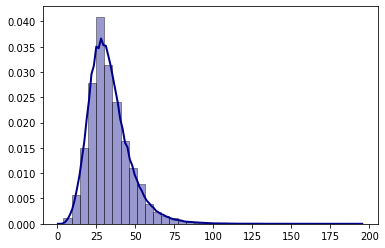

In [0]:
# Density Plot and Histogram of number of words in recipies
lengths = [len(s) for s in numerical_tokens]
sns.distplot(lengths, hist=True, kde=True,
             bins=int(180/5), color = 'darkblue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})

In [0]:
#limit data to recipies with less than X words
max_words = 75
numerical_tokens_limited = [i for i,j in zip(numerical_tokens,lengths) if j <= max_words]
IDs_limited = [i for i,j in zip(cleaned_recipes_IDs,lengths) if j <= max_words]
print(len(numerical_tokens_limited))

129270


In [0]:
#check if our baking data includes the recipes with nutritional info 
with open('/content/drive/My Drive/CS 263 Project/Raw Data/recipes_with_nutritional_info.json') as f:
  recipes_with_nutritional_info = json.load(f)

nutritional_ids = pd.DataFrame(recipes_with_nutritional_info)[["id"]]
nutritional_ids["nutritional"]=1
bake_ids = pd.DataFrame({'id':IDs_limited})
bake_ids["bake"]=1

joined_ids = pd.merge(bake_ids, nutritional_ids, on=['id'], how='outer')

joined_ids['nutritional'] = joined_ids['nutritional'].fillna(0)
joined_ids['bake'] = joined_ids['bake'].fillna(0)
joined_ids.groupby(['nutritional','bake']).size().reset_index().rename(columns={0:'count'})

,nutritional,bake,count
0,0.0,1.0,124265
1,1.0,0.0,46230
2,1.0,1.0,5005


In [0]:
#find overlap 
nutritional_bake_ids = joined_ids[joined_ids["bake"]==1 ][joined_ids["nutritional"]==1]

In [0]:
#create nutritional data categories

nutri_cats = pd.merge(pd.DataFrame(recipes_with_nutritional_info), nutritional_bake_ids, on=['id'], how='right')

nutri_cats = pd.DataFrame(nutri_cats)[["url","title","id","fsa_lights_per100g"]]
nutri_cats  = pd.concat([nutri_cats.drop(['fsa_lights_per100g'], axis=1), nutri_cats['fsa_lights_per100g'].apply(pd.Series)], axis=1)

uni_labels = nutri_cats.groupby(['fat','salt','sugars','saturates']).size().reset_index().rename(columns={0:'count'})
uni_labels['category_fat_salt_sugars_sats'] = uni_labels.index
nutri_cats = pd.merge(nutri_cats, uni_labels, on=['fat','salt','sugars','saturates'], how='left')

uni_labels = nutri_cats.groupby(['fat','salt','sugars']).size().reset_index().rename(columns={0:'count'})
uni_labels['category_fat_salt_sugars'] = uni_labels.index
nutri_cats = pd.merge(nutri_cats, uni_labels, on=['fat','salt','sugars'], how='left')

print(len(nutri_cats))
nutri_cats.head()

In [0]:
#save bake recipes with nutritional data to google drive 
import pickle
with open('/content/drive/My Drive/CS 263 Project/Final Project Data/nutritional_info.pickle', 'wb') as f:
    pickle.dump(nutri_cats, f)

In [0]:
#create train and test
numerical_tokens_train = numerical_tokens_limited[0:-10000]
numerical_tokens_test = numerical_tokens_limited[-10000:]
print(len(numerical_tokens_train))
print(len(numerical_tokens_test))
IDs_train = IDs_limited[0:-10000]
IDs_test = IDs_limited[-10000:]

In [0]:
#mask random 15% of words in each test data recipes
#exclude delimiters from masked words
#print(vocabulary.index2word[5]) #delimiter
#print(vocabulary.index2word[9]) #delimiter
from numpy.random import choice

def MaskRecipe(l,pct):
    ids = [i for i in range(len(l))]
    id_pool = [i for i,j in zip(ids,l) if j not in [5,9]]
    k = int(pct*len(l))+1
    new = l[:]
    masked_values = []
    for id, value in zip(choice(id_pool, size=k, replace=False), ['MASK']*k):
        masked_values.append(new[id])
        new[id] = value
    return [new,masked_values]

def MaskTest(TestData,pct):
    return [MaskRecipe(s,pct) for s in TestData]

#note that the entries of "numerical_tokens_test_masked" are lists with two sub lists:
#[1] the masked recipe list and [2] a list of the masked values
numerical_tokens_test_masked = MaskTest(numerical_tokens_test,0.15)

In [0]:
#save data to google drive
import pickle
baking_data = [joined_limited,cleaned_recipes,numerical_tokens_train,numerical_tokens_test,numerical_tokens_test_masked,IDs_train,IDs_test,vocabulary.index2word,vocabulary,cleaned_recipes_IDs]
with open('/content/drive/My Drive/CS 263 Project/Final Project Data/baking_data_title_ingredients.pickle', 'wb') as f:
    pickle.dump(baking_data, f)

In [0]:
#test loading data from google drive
with open('/content/drive/My Drive/CS 263 Project/Final Project Data/baking_data_title_ingredients.pickle','rb') as f:
    loaded_obj = pickle.load(f)
#check that data loaded
check = loaded_obj[0]
check.head(1)